# Classificação de Sentimentos de Textos em Português 

Este notebook aborda o uso de Machine learning para classificar se um comentário é **bom** ou **ruim** com base em comentários de produto ou serviços de empresas.
Para comparar o resultado obtido pelo modelo de Machine Learning será utilizado um modelo de LLM e além da acurácia será obervado o custo computacional. 

-Dataset: https://www.kaggle.com/datasets/fredericods/ptbr-sentiment-analysis-datasets/data

## Importantando Bibliotecas

In [1]:
# visualização gráfica
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# separação de dataset
from sklearn.model_selection import train_test_split
# vetorização
from sklearn.feature_extraction.text import TfidfVectorizer

# modelos de Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# métricas de avaliação
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import utils

# NLP
import nltk
from nltk.corpus import stopwords
import string

# Baixando stopwords do NLTK
nltk.download('stopwords')
nltk.download('rslp')  # Stemmer para português



[nltk_data] Downloading package stopwords to C:\Users\Bruno
[nltk_data]     Dutra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to C:\Users\Bruno
[nltk_data]     Dutra\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## Explorando os dados 

**Carregando o dataset: Buscapé**

In [2]:
data = pd.read_csv('Datasets/buscape.csv')
data.head(10)

,original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
0,4_55516,"Estou muito satisfeito, o visor é melhor do qu...","estou muito satisfeito, o visor e melhor do qu...","['estou', 'muito', 'satisfeito', 'visor', 'mel...",1.0,4,1,1
1,minus_1_105339,"""muito boa\n\nO que gostei: preco\n\nO que não...","""muito boa\n\no que gostei: preco\n\no que nao...","['muito', 'boa', 'que', 'gostei', 'preco', 'qu...",1.0,5,1,1
2,23_382139,"Rápida, ótima qualidade de impressão e fácil d...","rapida, otima qualidade de impressao e facil d...","['rapida', 'otima', 'qualidade', 'de', 'impres...",1.0,5,1,1
3,2_446456,Produto de ótima qualidade em todos os quesito!,produto de otima qualidade em todos os quesito!,"['produto', 'de', 'otima', 'qualidade', 'em', ...",1.0,5,1,1
4,0_11324,Precisava comprar uma tv compatível com meu dv...,precisava comprar uma tv compativel com meu dv...,"['precisava', 'comprar', 'uma', 'tv', 'compati...",1.0,5,1,1
5,0_466829,"eu adorei este secador é muito bom,potente e d...","eu adorei este secador e muito bom,potente e d...","['eu', 'adorei', 'este', 'secador', 'muito', '...",1.0,5,1,1
6,0_369493,bom\n\nO que gostei: muitos aplicativos gratis...,bom\n\no que gostei: muitos aplicativos gratis...,"['bom', 'que', 'gostei', 'muitos', 'aplicativo...",NaN,3,-1,1
7,0_135152,positiva\n\nO que gostei: cumpriu com as espec...,positiva\n\no que gostei: cumpriu com as espec...,"['positiva', 'que', 'gostei', 'cumpriu', 'com'...",1.0,4,1,1
8,0_299007,"Muito satisfeita com o telefone, atendeu as mi...","muito satisfeita com o telefone, atendeu as mi...","['muito', 'satisfeita', 'com', 'telefone', 'at...",1.0,4,1,1
9,0_198604,Estou muito contente com a utlização da maquin...,estou muito contente com a utlizacao da maquin...,"['estou', 'muito', 'contente', 'com', 'utlizac...",1.0,4,1,1


**Removendo Colunas Irrelevatens**

In [3]:
data.drop(
    columns = [
        "original_index",
        "review_text_processed", 
        "review_text_tokenized",
        "kfold_polarity",
        "kfold_rating",
    ],
    inplace = True
)
data

,review_text,polarity,rating
0,"Estou muito satisfeito, o visor é melhor do qu...",1.0,4
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1.0,5
2,"Rápida, ótima qualidade de impressão e fácil d...",1.0,5
3,Produto de ótima qualidade em todos os quesito!,1.0,5
4,Precisava comprar uma tv compatível com meu dv...,1.0,5
...,...,...,...
84986,"Produto muito bom, simples e barato",1.0,5
84987,O esquema antigo de desmontagem e limpeza das ...,NaN,3
84988,Esse jogo é muito maneiro é um jogo onde vc te...,1.0,5
84989,Muito bom e intuitivo!\n\nO que gostei: Educa ...,NaN,3


**Análise e remoção de dados Nulos**

Número total de amostras: 66817
Número de amostras com label Nulo ou NaN: 11364, isso equivale a 17.008 % do Dataset


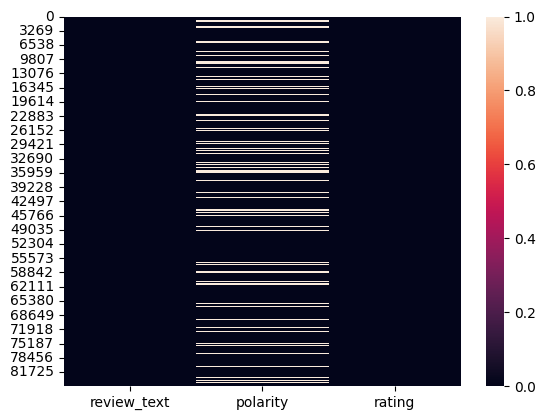

In [4]:
# visualização de dados nulos por coluna
sns.heatmap(data.isnull())

# Quantidade de dados Nulos
total_samples = int(data["polarity"].sum())
null_samples = data["polarity"].isnull().sum()

print(f'Número total de amostras: {total_samples}')
print(f'Número de amostras com label Nulo ou NaN: {null_samples}, isso equivale a {null_samples*100/total_samples :.3f} % do Dataset')

#apaga registros nulos
data.dropna(inplace=True)

**Análise dos comentários Positivos e Negativos**

**Positivos**

In [32]:
data[data['polarity']==1][['review_text','polarity','rating']]

,review_text,polarity,rating
0,"Estou muito satisfeito, o visor é melhor do qu...",1.0,4
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1.0,5
2,"Rápida, ótima qualidade de impressão e fácil d...",1.0,5
3,Produto de ótima qualidade em todos os quesito!,1.0,5
4,Precisava comprar uma tv compatível com meu dv...,1.0,5
...,...,...,...
84984,Excelente custo-benefício apresentado por este...,1.0,5
84985,"Game muito legal, com uma grande variedade de ...",1.0,5
84986,"Produto muito bom, simples e barato",1.0,5
84988,Esse jogo é muito maneiro é um jogo onde vc te...,1.0,5


In [38]:
for idx, text in enumerate(data[data['polarity']==1]['review_text'].sample(3)):
    print(f'Comentário {idx}: \n')
    print(text)
    print('--------------------------------------------------------')

Comentário 0: 

Recomendo este produto porque reune em um só produto a qualidade de imagens, baixo custo e ampla rede de oficinas autorizadas.

O que gostei: Potencia

O que não gostei: preço
--------------------------------------------------------
Comentário 1: 

Esse Kenzo é sofisticado, excelente para ocasiões especiais. Durante o dia é bom usar bem pouquinho, já que a fragrância dele é um EDP e muito marcante.


O que gostei: Excelente fixação!

O que não gostei: absolutamente nada!
--------------------------------------------------------
Comentário 2: 

APESAR DE SER UMA MÁQUINA RELATIVAMENTE GRANDE, É UM ÓTIMO APARELHO PRINCIPALMENTE PRA QUEM PRECISA TIRAR FOTOS NO DIA A DIA.

O que gostei: ÓTIMO CUSTO BENEFÍCIO

O que não gostei: O PRODUTO É UM POUCO GRANDE
--------------------------------------------------------


**Negativos**

In [39]:
data[data['polarity']==0][['review_text','polarity','rating']]

,review_text,polarity,rating
11,"nao comparia novamente essa marca, pois paguei...",0.0,2
48,tem uma boa aderencia te da mas agilidades no ...,0.0,2
54,"Somente mais um jogo do estilo, nada realmente...",0.0,2
79,Estou insatisfeito com o produto porque a Elet...,0.0,1
90,"SANSUNG É MINHA PIOR COMPRA que já fiz, não re...",0.0,1
...,...,...,...
84935,Ele e um celular funcional para quem deseja mu...,0.0,2
84941,Produtos NKS. Nunca mais. Uma porcaria e o SAC...,0.0,1
84950,Comprei este por ele ser mais acessivel (valor...,0.0,1
84964,comprei o ar condicionado a pouco mais de um a...,0.0,2


In [40]:
for idx, text in enumerate(data[data['polarity']==0]['review_text'].sample(3)):
    print(f'Comentário {idx}: \n')
    print(text)
    print('--------------------------------------------------------')

Comentário 0: 

Não é possivel tanta queima de reistencia como ocorre. Tudo está em ordem e a resistencia não dura sequer 15 dias. ABSURDO.
Não recomendo a ninguem.

O que gostei: Boa vazão de agua

O que não gostei: Resitencia nao dura nada, e o *** *** é terrivel
--------------------------------------------------------
Comentário 1: 

Antes de comprar no site siciliano.com leiam pelo que estou passando.
Fiz o pedido de compra de uma TV e eles tentaram entregar-la sem nota fiscal e após solicitação de cancelamento da compra e retirada do produto os mesmos após uma semana apareceram com a TV e uma nota fiscal, só que o produto não funcionou. Continuei solicitando a devolução e cancelamento da compra e eles apenas informam que abriram um pedido e ninguém entra em contato ou manda email para esclarecer e solucionar o problema. Esta novela já tem mais de 10 dias...

O que gostei: não consegui usar

O que não gostei: a empresa onde comprei
--------------------------------------------------

**Análise da Distribuição das classes**

polarity
1.0    66816
0.0     6810
Name: count, dtype: int64


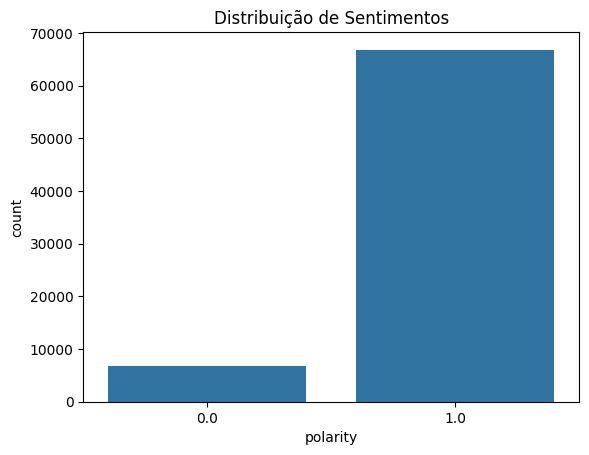

In [ ]:
#print(data.info())  # Informações gerais
print(data['polarity'].value_counts())  # Distribuição das classes

# Visualizando a distribuição das classes
sns.countplot(x='polarity', data=data)
plt.title('Distribuição de Sentimentos')
plt.show()


## Pré processamento dos dados 

**Ajuste de Distribuição das Classes**

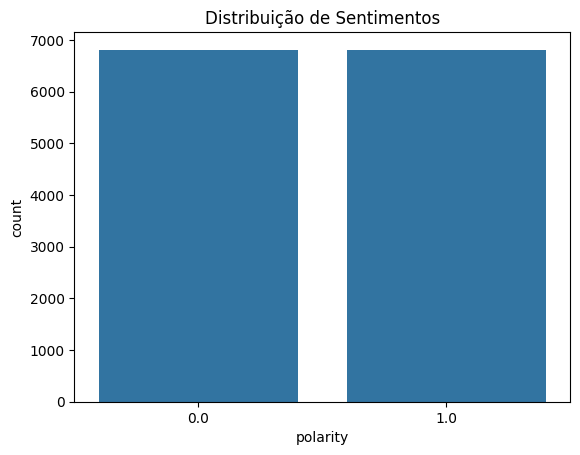

In [7]:
positive_partial = data.query("polarity == 1").sample(6810)

negative_total = data.query("polarity == 0")
dataset = pd.concat([positive_partial, negative_total])
dataset.shape

# Visualizando a distribuição das classes
sns.countplot(x='polarity', data=dataset)
plt.title('Distribuição de Sentimentos')
plt.show()

**Limpeza de pontuação e padronização em caixa baixa**

In [8]:
# Função de limpeza
def preprocess_text(text):
    stop_words = set(stopwords.words('portuguese'))
    text = text.lower()  # Lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove pontuações
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Aplicando a função
dataset['cleaned_text'] = dataset['review_text'].apply(preprocess_text)

In [9]:
dataset[dataset['polarity']==1][['cleaned_text','polarity']]

,cleaned_text,polarity
70640,exelente celular precisa viajando acessar inte...,1.0
50277,produto excelente gostei encontrei,1.0
27377,bom nota 10,1.0
56748,produto bom pode comprar medo arrependimento p...,1.0
58770,vale pena pra verao preco baixo pra muita dive...,1.0
...,...,...
10991,tablet pouco 1 mês agr apresentou problema gra...,1.0
82935,procura geladeira pequena vi apaixonei pois ta...,1.0
35517,decidi produto satisfeita funcionalidades pass...,1.0
74306,ótimo produto procurando acredito encontrei go...,1.0


**Vetorização**

In [10]:
# Seleciona as colunas 'cleaned_text' e 'polarity' do dataset para criação dos conjuntos de dados X e y
X = dataset['cleaned_text']
y = dataset['polarity']

# Realiza a vetorização dos textos utilizando TF-IDF (Term Frequency-Inverse Document Frequency)
#   - TF-IDF é uma técnica utilizada para transformar texto em vetores numéricos, que podem ser processados por algoritmos de aprendizado de máquina.
#   - Remove ruído: palavras comuns, mas irrelevantes, como "de", "a", "o", têm pouco peso.
#   - Captura relevância: destaca palavras que diferenciam documentos.
#   - Escalável: funciona bem em conjuntos de dados grandes.

# Cria uma instância do TfidfVectorizer com o parâmetro max_features=5000, que limita o número de características (palavras) consideradas
vectorizer = TfidfVectorizer(max_features=5000)

# Aplica a vetorização TF-IDF ao conjunto de dados X e converte o resultado para uma matriz (array)
#   - O método fit_transform() significa que o modelo se ajusta aos dados e, em seguida, transforma os dados de acordo com o modelo ajustado.
#   - O resultado é uma matriz de vetores de pesos TF-IDF para cada documento no conjunto de dados.
X = vectorizer.fit_transform(X).toarray()

## Divisão do Dataset para o Treino

In [11]:
# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Treinamento dos Modelos de ML

**Random Forest**

In [12]:
# Treinando o modelo de Floresta Aleatória
model_rf = RandomForestClassifier(n_estimators=300, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

**Support Vector Machine**

In [13]:
# Treinando o modelo de Suporte de Vetor (SVC)
model_svc = SVC(kernel='linear', C=1)
model_svc.fit(X_train, y_train)

y_pred_svc = model_svc.predict(X_test)

**Logistic Regression**

In [14]:
# Treinando o modelo Regressão Logística
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

## Visualizando Resultados

**Resultados do Random Forest**

F1-score: 82.064 %


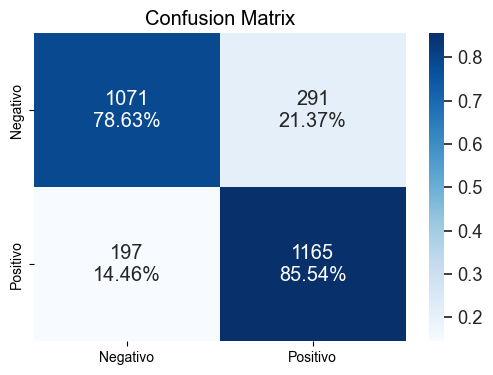

In [16]:
# Matriz de confusão
cfm_lr = utils.plot_confusion_matrix(['Negativo','Positivo',], labels_val = y_test, labels_val_predicted= y_pred_rf, Get_matrix=True)

metrics_per_class_rf, pr_rf, rec_rf, f1_rf, acc_rf = utils.model_average_std_metrics(cf_matrix=cfm_lr, Verbose=False) 
print(f'F1-score: {f1_rf[0]*100 :.3f} %')

**Resultados do Support vector Machine**

F1-score: 83.608 %


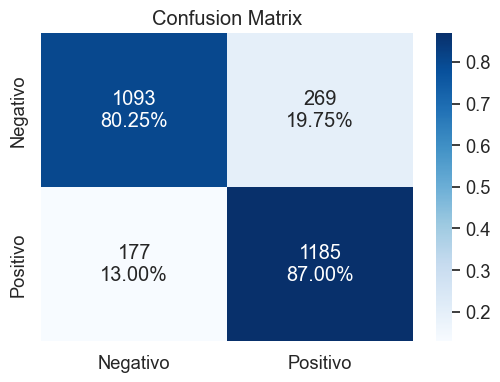

In [17]:
# Matriz de confusão
cfm_svc = utils.plot_confusion_matrix(['Negativo','Positivo',], labels_val = y_test, labels_val_predicted= y_pred_svc, Get_matrix=True)

metrics_per_class_svc, pr_svc, rec_svc, f1_svc, acc_svc = utils.model_average_std_metrics(cf_matrix=cfm_svc, Verbose=False) 
print(f'F1-score: {f1_svc[0]*100 :.3f} %')

**Resultados do Logistic Regression**

F1-score: 84.021 %


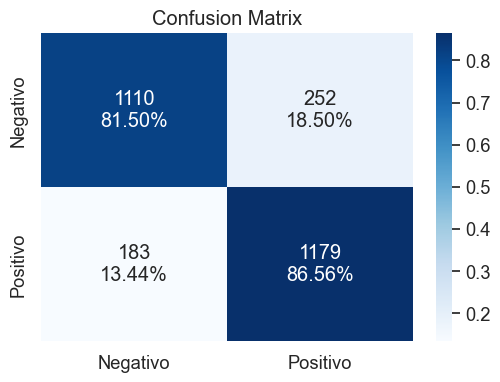

In [18]:
# Matriz de confusão
cfm_lr = utils.plot_confusion_matrix(['Negativo','Positivo',], labels_val = y_test, labels_val_predicted= y_pred_lr, Get_matrix=True)

metrics_per_class_lr, pr_lr, rec_lr, f1_lr, acc_lr = utils.model_average_std_metrics(cf_matrix=cfm_lr, Verbose=False) 
print(f'F1-score: {f1_lr[0]*100 :.3f} %')

**Resultado Gráfico do Comparativo dos Modelos com as Métricas**

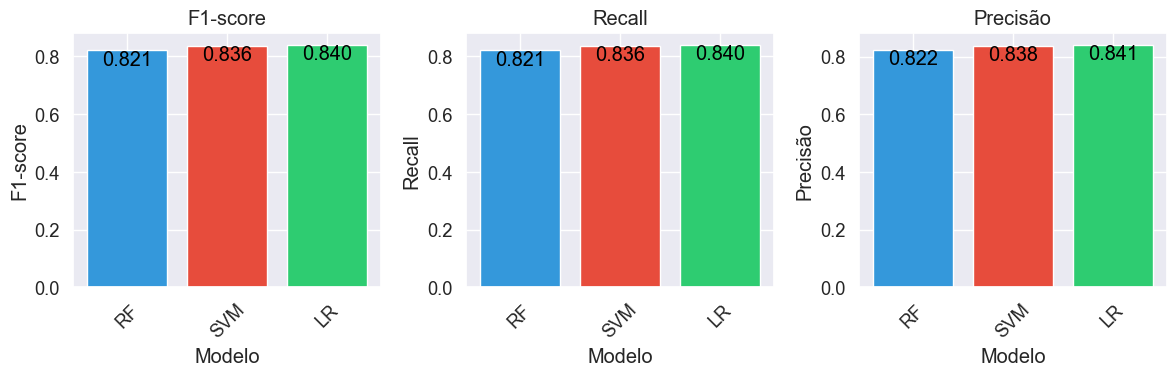

In [20]:
# Cálculo das métricas para cada modelo
f1_scores = [f1_rf[0], f1_svc[0], f1_lr[0]]

recalls =[rec_rf[0], rec_svc[0], rec_lr[0]]

precisions = [pr_rf[0], pr_svc[0], pr_lr[0]]

# Criação dos gráficos
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(['RF', 'SVM', 'LR'], f1_scores, color=['#3498db', '#e74c3c', '#2ecc71'])
plt.xlabel('Modelo')
plt.ylabel('F1-score')
plt.title('F1-score')
plt.xticks(rotation=45)  # Rotaciona o eixo x para evitar sobreposição
for i, v in enumerate(f1_scores):
    plt.text(i, v - 0.05, f'{v:.3f}', color='black', ha='center')

plt.subplot(1, 3, 2)
plt.bar(['RF', 'SVM', 'LR'], recalls, color=['#3498db', '#e74c3c', '#2ecc71'])
plt.xlabel('Modelo')
plt.ylabel('Recall')
plt.title('Recall')
plt.xticks(rotation=45)  # Rotaciona o eixo x para evitar sobreposição
for i, v in enumerate(recalls):
    plt.text(i, v - 0.05, f'{v:.3f}', color='black', ha='center')

plt.subplot(1, 3, 3)
plt.bar(['RF', 'SVM', 'LR'], precisions, color=['#3498db', '#e74c3c', '#2ecc71'])
plt.xlabel('Modelo')
plt.ylabel('Precisão')
plt.title('Precisão')
plt.xticks(rotation=45)  # Rotaciona o eixo x para evitar sobreposição
for i, v in enumerate(precisions):
    plt.text(i, v - 0.05, f'{v:.3f}', color='black', ha='center')

plt.tight_layout()
plt.show()

**Feature Importance com o RF**

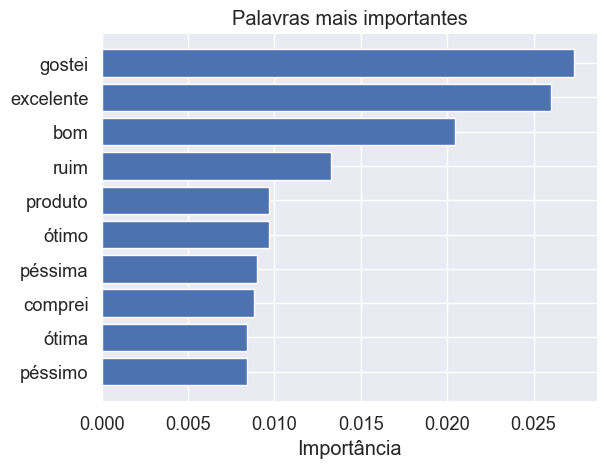

In [42]:
# Palavras mais importantes no modelo
importances = model_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10
features = vectorizer.get_feature_names_out()

plt.figure()
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importância')
plt.title('Palavras mais importantes')
plt.show()

## Inferência

In [21]:
# Sorteio de 10 Amostras para a Inferência
inference_dataset=dataset.sample(10)
inference_dataset

,review_text,polarity,rating,cleaned_text
5789,Meu sogro tem e a imagem é simplesmente maravi...,1.0,5,sogro imagem simplesmente maravilhosa
46044,"Olá Meu nome e Rebeca , tenho o produto Midea...",1.0,5,olá nome rebeca produto midea mpt1010cr portát...
57729,"uma porcaria,não vale nada não gaste seu suado...",0.0,1,porcarianão vale nada gaste suado dinheiro por...
75088,Uma excelente bicicleta para iniciantes. As ro...,1.0,5,excelente bicicleta iniciantes rodinhas oferec...
5720,"microondas tem a porta muito dura de abrir, el...",0.0,2,microondas porta dura abrir vem pra frente cad...
5873,Se quer qualidade e um bom produto adquirir sc...,1.0,4,quer qualidade bom produto adquirir scarlet tu...
30049,O sistema giratório é muito eficiente pois jog...,1.0,5,sistema giratório eficiente pois joga calor to...
77224,OTIMO POI O PACOTE OFFICE ME AUXILIA MUITO NO...,1.0,5,otimo poi pacote office auxilia dia dia uso ta...
40261,Bom\n\nO que gostei: Bom\n\nO que não gostei: ...,0.0,1,bom gostei bom gostei nenhuma
83543,"Esse celular é ótimo, pequeno e tem de tudo! S...",1.0,4,celular ótimo pequeno tudo super fácil manusea...


In [45]:
# Aplica a vetorização TF-IDF ao conjunto de Teste
X_inference = vectorizer.transform(inference_dataset['cleaned_text']).toarray()

# inferência e mapeamento para Positivo e Negativo
ml_response=['Positivo' if response[1] >= 0.55 else  'Negativo' for response in model_lr.predict_proba(X_inference)]

# adciona a coluna do Dataframe
inference_dataset['sentimento_ML_LR'] = ml_response

In [47]:
inference_dataset[['review_text','polarity','sentimento_ML_LR']]

,review_text,polarity,sentimento_ML_LR
5789,Meu sogro tem e a imagem é simplesmente maravi...,1.0,Positivo
46044,"Olá Meu nome e Rebeca , tenho o produto Midea...",1.0,Positivo
57729,"uma porcaria,não vale nada não gaste seu suado...",0.0,Negativo
75088,Uma excelente bicicleta para iniciantes. As ro...,1.0,Positivo
5720,"microondas tem a porta muito dura de abrir, el...",0.0,Negativo
5873,Se quer qualidade e um bom produto adquirir sc...,1.0,Positivo
30049,O sistema giratório é muito eficiente pois jog...,1.0,Positivo
77224,OTIMO POI O PACOTE OFFICE ME AUXILIA MUITO NO...,1.0,Positivo
40261,Bom\n\nO que gostei: Bom\n\nO que não gostei: ...,0.0,Positivo
83543,"Esse celular é ótimo, pequeno e tem de tudo! S...",1.0,Positivo


## Comparação com uma LLM- deeplearning

In [43]:
import os
# importa a biblioteca de requisição da API 
from groq import Groq
import pandas as pd
import json
# Configure a chave de API do Groq
GROQ_API_KEY= "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"
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Defina as frases que você deseja analisar
frases = inference_dataset['review_text']

# Crie uma lista para armazenar os resultados
resultados = []

# Loop pelas frases
for frase in frases:
    # Envie a requisição para a API do Groq
    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": "Classifique a seguinte frase como Negativo ou Positivo: " + frase
            }
        ],
        model="llama-3.3-70b-versatile",
    )
    
    # Verifique o sentimento da frase
    resposta = json.loads(response.json())
    if isinstance(resposta, dict) and 'choices' in resposta and len(resposta['choices']) > 0:
        texto_resposta = resposta['choices'][0]['message']['content']
        if "Negativo" in texto_resposta:
            resultados.append("Negativo")
        elif "Positivo" in texto_resposta:
            resultados.append("Positivo")
        else:
            resultados.append("Não foi possível determinar o sentimento")
    else:
        resultados.append("Não foi possível determinar o sentimento")

# Adicione os resultados ao DataFrame
inference_dataset['sentimento_llm'] = resultados

# Exiba o DataFrame com os resultados
inference_dataset[['review_text','polarity','sentimento_ML_LR','sentimento_llm']]

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11192\1944767258.py:34: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  resposta = json.loads(response.json())


,review_text,polarity,sentimento_ML_LR,sentimento_llm
5789,Meu sogro tem e a imagem é simplesmente maravi...,1.0,Positivo,Positivo
46044,"Olá Meu nome e Rebeca , tenho o produto Midea...",1.0,Positivo,Positivo
57729,"uma porcaria,não vale nada não gaste seu suado...",0.0,Negativo,Não foi possível determinar o sentimento
75088,Uma excelente bicicleta para iniciantes. As ro...,1.0,Positivo,Positivo
5720,"microondas tem a porta muito dura de abrir, el...",0.0,Negativo,Negativo
5873,Se quer qualidade e um bom produto adquirir sc...,1.0,Positivo,Positivo
30049,O sistema giratório é muito eficiente pois jog...,1.0,Positivo,Positivo
77224,OTIMO POI O PACOTE OFFICE ME AUXILIA MUITO NO...,1.0,Positivo,Positivo
40261,Bom\n\nO que gostei: Bom\n\nO que não gostei: ...,0.0,Positivo,Positivo
83543,"Esse celular é ótimo, pequeno e tem de tudo! S...",1.0,Positivo,Positivo


In [51]:
print(inference_dataset.iloc[-2,0])

Bom

O que gostei: Bom

O que não gostei: nenhuma
